# Práctica 24/25 - Generative AI Authorship Verification

## Índice

1. Integrantes del equipo

2. Librerías

3. Procesamiento de los datos  
<div style="margin-left:40px;">
    3.1. Carga de datos -> Documentarlo<br>
    3.2. Exploración y visualización de los datos -> Documentarlo<br>
    3.3. Preprocesamiento de los datos -> Documentarlo<br>
    3.4. Construcción del dataset y configuración del DataCollator -> Documentarlo<br>
</div>

4. Experimentos  
<div style="margin-left:40px;">
    4.1. Estudio de los modelos disponibles -> Documentarlo<br>
    4.2. Baseline: Descripción y primeros resultados -> Documentarlo, aqui podríamos poner cuando no entrenaba bien<br>
    4.3. Fine-Tuning -> Depende de nuestras ganas<br>
    <div style="margin-left:20px;">
        4.3.1. Arquitecturas y diseño de los modelos<br>
        4.3.2. Entrenamientos<br>
    </div>
</div>

5. Resultados  
<div style="margin-left:40px;">
    5.1. Métricas utilizadas -> Sencillo<br>
    5.2. Comparativa entre nuestros modelos -> Sencillo<br>
    5.3. Comparativa de resultados con los modelos base y otras propuestas publicadas -> Complicado pero lo pone en el doc de la entrega<br>
</div>

6. Conclusiones

7. Trabajo Futuro  
<div style="margin-left:40px;">
    7.1. Posibles mejoras al modelo -> Ni idea<br>
    7.2. Nuevas técnicas por explorar -> Prompt Engineering??<br>
    7.3. Ampliación a otros datasets o tareas similares -> Dataset de Kaggle??<br>
</div>


## Integrantes del equipo
* Alejandro Cortijo Benito
* Alejandro García Mota

## Librerías

In [ ]:
# Sistema
import os
from glob import glob
import logging

logging.disable(logging.WARNING)

# Procesamiento de los datos 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split

# Experimentos
import torch
import transformers
from transformers import AutoTokenizer
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Resultados
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_fscore_support, brier_score_loss

# Configuración de CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Carga de datos

In [41]:
df_human = pd.read_json('data/human.jsonl', lines=True)
df_human

,id,text
0,articles-cleaned-truncated/news-2021-01-01-202...,Inaugural Address by President Joseph R. Biden...
1,articles-cleaned-truncated/news-2021-01-01-202...,Fact check: Biden inauguration impacted by pan...
2,articles-cleaned-truncated/news-2021-01-01-202...,Highlights from Joe Biden's 2021 inauguration\...
3,articles-cleaned-truncated/news-2021-01-01-202...,"Biden takes the helm, appeals for unity to tak..."
4,articles-cleaned-truncated/news-2021-01-01-202...,'The Hill We Climb': Read Amanda Gorman's inau...
...,...,...
1082,articles-cleaned-truncated/news-2021-01-01-202...,How amateur detectives on social media helped ...
1083,articles-cleaned-truncated/news-2021-01-01-202...,Authorities searching for missing 22-year-old ...
1084,articles-cleaned-truncated/news-2021-01-01-202...,Univ. of Wisconsin Oshkosh student helping Gab...
1085,articles-cleaned-truncated/news-2021-01-01-202...,Did the Internet Actually Help Find Gabby Peti...


In [42]:
machines_files = glob('data/machine/*.jsonl')
df_human_temp = df_human.reset_index(drop=True)
df_human_temp['label'] = 0

df_machine = pd.read_json(machines_files[0], lines=True)
for file in machines_files[1:]:
    df_current = pd.read_json(file, lines=True)
    df_machine = pd.concat([df_machine, df_current])

df_machine

,id,text
0,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Inaugural Address: President Joseph R. Biden J...
1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Setting the Record Straight: Fact-Checking the...
2,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes the Oath of Office as 46th Pre...
3,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes Oath as 46th President of Unit...
4,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Amanda Gorman's Inspiring Poem Celebrates Hope...
...,...,...
1082,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,'The Disappearance of Gabby Petito' – A Compre...
1083,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,"Utah State Police Search for Gabby Petito, Tra..."
1084,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,McKenna's Lost Friend: Debunking the Evidence ...
1085,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,"""Gunshots Found in Florida Nature Preserve: A ..."


### Exploración y visualización de los datos

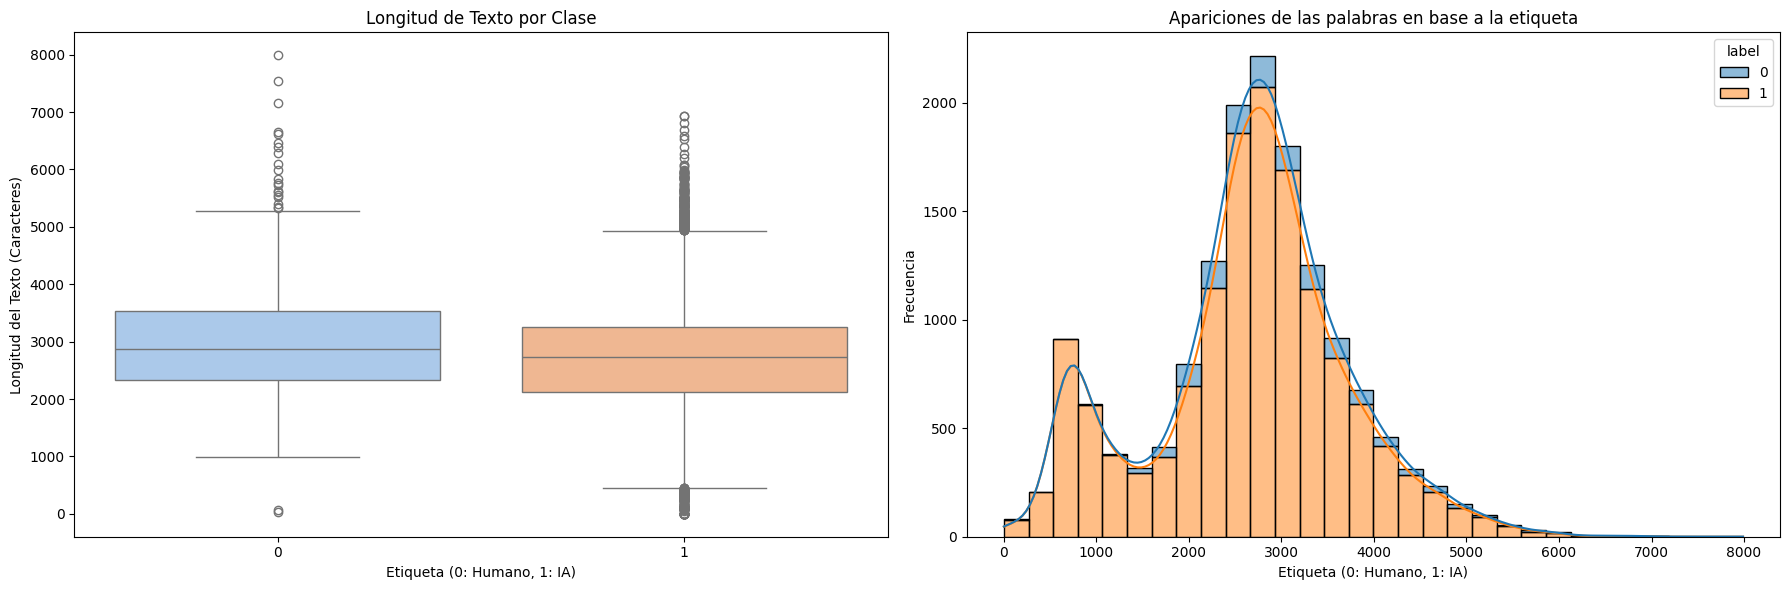

In [ ]:
df_machine_temp = df_machine.reset_index(drop=True)
df_machine_temp['label'] = 1

df_temp = pd.concat([df_human_temp, df_machine_temp], axis=0, ignore_index=True)

df_temp["text_length"] = df_temp["text"].apply(len)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# 1. Gráfico de la longitud del texto (Boxplot)
sns.boxplot(data=df_temp, x="label", y="text_length", ax=ax[0], palette='pastel', hue="label", dodge=False, legend=False)
ax[0].set_title("Longitud de Texto por Clase")
ax[0].set_xlabel("Etiqueta (0: Humano, 1: IA)")
ax[0].set_ylabel("Longitud del Texto (Caracteres)")

# 2. Gráfico de histograma apilado
sns.histplot(data=df_temp, x='text_length', hue='label', multiple='stack', bins=30, kde=True, ax=ax[1])
ax[1].set_title('Apariciones de las palabras en base a la etiqueta')
ax[1].set_xlabel("Etiqueta (0: Humano, 1: IA)")  
ax[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

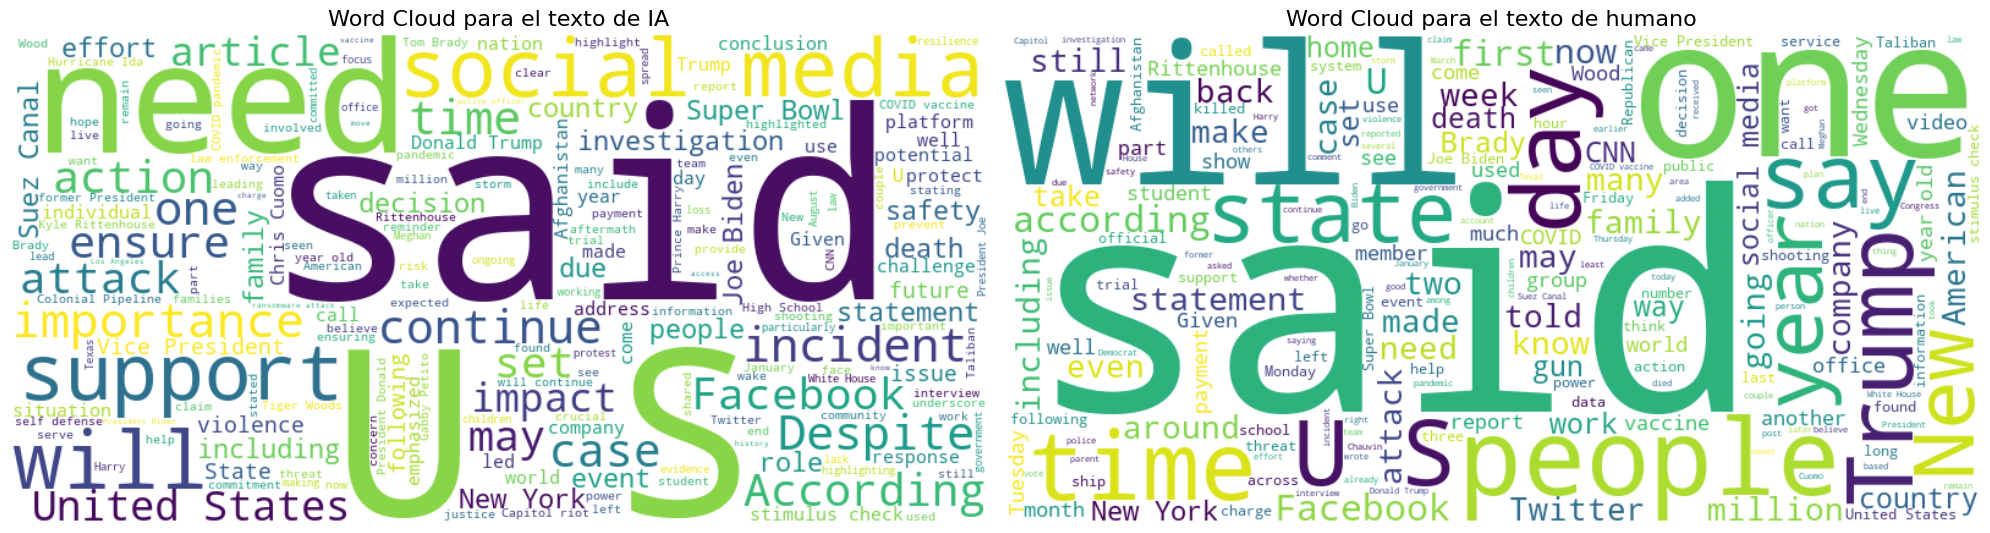

In [44]:
def plot_wordclouds(text1, text2, title1, title2):
    wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(text1)
    wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(text2)
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    axs[0].imshow(wordcloud1, interpolation='bilinear')
    axs[0].axis('off')  
    axs[0].set_title(title1, fontsize=16)

    axs[1].imshow(wordcloud2, interpolation='bilinear')
    axs[1].axis('off')  
    axs[1].set_title(title2, fontsize=16)
    
    plt.tight_layout()
    plt.show()

text_machine = ' '.join(df_machine['text'].astype(str))
text_humans = ' '.join(df_human['text'].astype(str))

# Generar las nubes de palabras
plot_wordclouds(text_machine, text_humans, title1='Word Cloud para el texto de IA', title2='Word Cloud para el texto de humano')


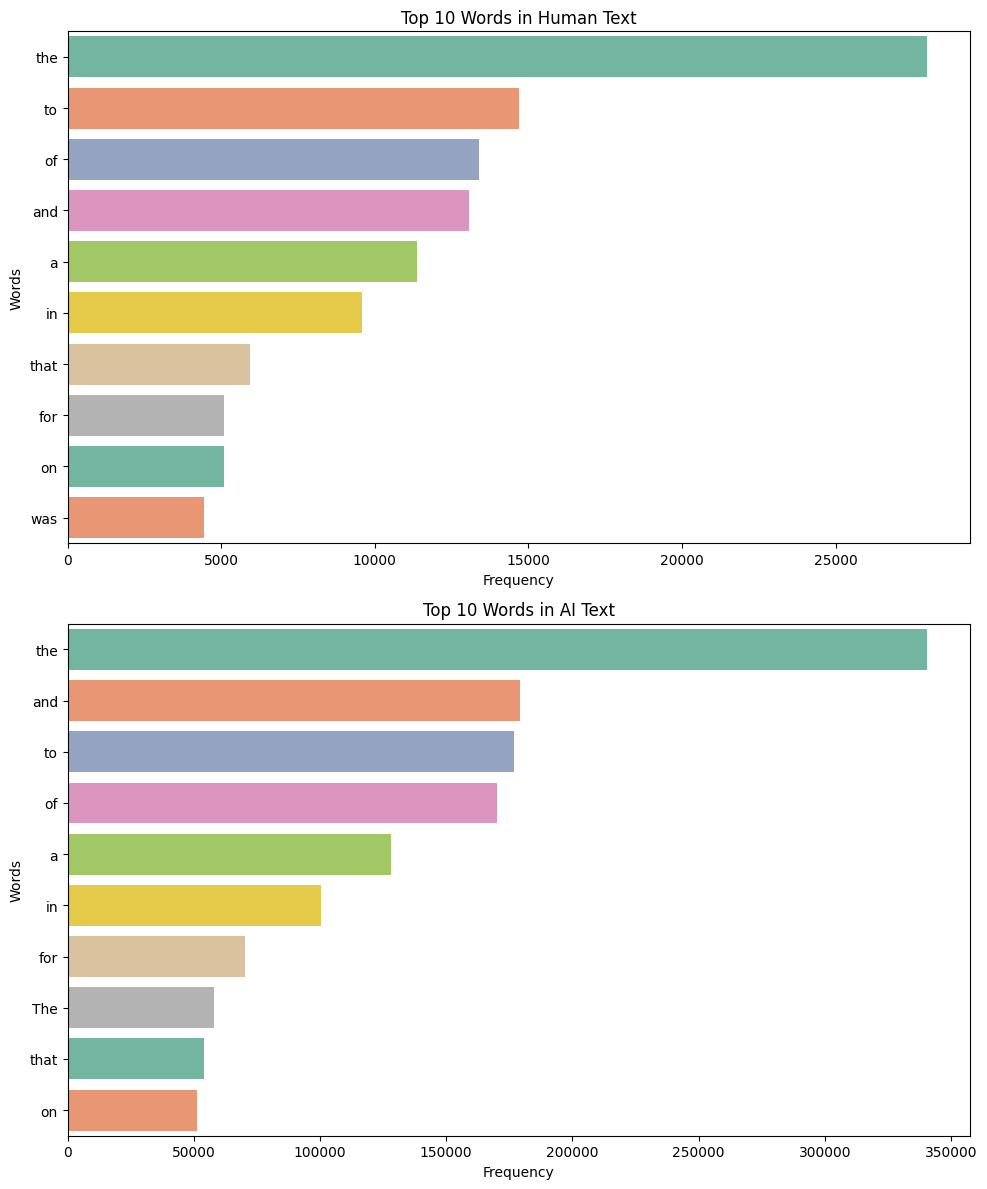

In [67]:
# Función para calcular las frecuencias de palabras
def get_word_frequencies(text):
    words = text.split()
    word_counts = Counter(words)  
    return word_counts

df_human['word_frequencies'] = df_human['text'].apply(get_word_frequencies)
human_frequencies = df_human['word_frequencies'].sum()  # Sumar las frecuencias de todas las filas de texto humano

human_freq_df = pd.DataFrame(human_frequencies.items(), columns=['Word', 'Frequency'])
top_human_words = human_freq_df.nlargest(10, 'Frequency')

# Obtener las frecuencias de palabras para texto de IA
df_machine['word_frequencies'] = df_machine['text'].apply(get_word_frequencies)
machine_frequencies = df_machine['word_frequencies'].sum()  # Sumar las frecuencias de todas las filas de texto de IA

machine_freq_df = pd.DataFrame(machine_frequencies.items(), columns=['Word', 'Frequency'])
top_machine_words = machine_freq_df.nlargest(10, 'Frequency')

fig, ax = plt.subplots(2, 1, figsize=(10, 12)) 

sns.barplot(x='Frequency', y='Word', data=top_human_words, ax=ax[0], hue='Word', palette='Set2', legend=False)
ax[0].set_title('Top 10 Words in Human Text')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Words')

sns.barplot(x='Frequency', y='Word', data=top_machine_words, ax=ax[1], hue='Word', palette='Set2', legend=False)
ax[1].set_title('Top 10 Words in AI Text')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Words')

plt.tight_layout()
plt.show()


In [45]:
machines_files = glob('data/machine/*.jsonl')

df_ids = pd.read_json('data/human.jsonl', lines=True)
df_ids = df_ids[['id']]
df_ids["id"] = df_ids["id"].str.split('/').str[1:].str.join('/')
df_ids

,id
0,news-2021-01-01-2021-12-31-bideninauguration/a...
1,news-2021-01-01-2021-12-31-bideninauguration/a...
2,news-2021-01-01-2021-12-31-bideninauguration/a...
3,news-2021-01-01-2021-12-31-bideninauguration/a...
4,news-2021-01-01-2021-12-31-bideninauguration/a...
...,...
1082,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1083,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1084,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1085,news-2021-01-01-2021-12-31-wyominggabbypetito/...


In [46]:
train_ids_df, temp_df = train_test_split(df_ids, test_size=0.3, random_state=42)
val_ids_df, test_ids_df = train_test_split(temp_df, test_size=1/3, random_state=42)

train_ids_df.shape, val_ids_df.shape, test_ids_df.shape

((760, 1), (218, 1), (109, 1))

In [47]:
df_human["id"] = df_human["id"].str.split('/').str[1:].str.join('/')
df_machine["id"] = df_machine["id"].str.split('/').str[1:].str.join('/')

df_combined = pd.merge(df_human, df_machine, on="id", suffixes=("_1", "_2"))
df_combined['target_human'] = 1
df_combined['target_machine'] = 0
df_combined = df_combined[['id', 'text_1', 'target_human', 'text_2', 'target_machine']]
df_combined

,id,text_1,target_human,text_2,target_machine
0,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Inaugural Address: President Joseph R. Biden J...,0
1,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,What should be the focus of the speech? The In...,0
2,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address Highlights Triumph o...,0
3,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address: A Clarion Call for ...,0
4,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,"President Biden Emphasizes Unity, Democracy, a...",0
...,...,...,...,...,...
14126,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Long Island Surf Shop Owner Reme...,0
14127,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Surf Shop Owner in Hometown Reme...,0
14128,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Kind-Hearted Sou...,0
14129,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Super Kind-Heart...,0


In [48]:
random_indices = df_combined.sample(frac=0.5, random_state=42).index
df_combined.loc[random_indices, ['text_1', 'text_2']] = df_combined.loc[random_indices, ['text_2', 'text_1']].values
df_combined.loc[random_indices, ['target_human']] = 0
df_combined.loc[random_indices, ['target_machine']] = 1
df_combined['target_tuple'] = list(zip(df_combined['target_human'], df_combined['target_machine']))
df_combined = df_combined[['id', 'text_1', 'target_human', 'text_2', 'target_machine', 'target_tuple']]
df_combined

,id,text_1,target_human,text_2,target_machine,target_tuple
0,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address: President Joseph R. Biden J...,0,Inaugural Address by President Joseph R. Biden...,1,"(0, 1)"
1,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,What should be the focus of the speech? The In...,0,"(1, 0)"
2,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address Highlights Triumph o...,0,"(1, 0)"
3,news-2021-01-01-2021-12-31-bideninauguration/a...,Biden's Inaugural Address: A Clarion Call for ...,0,Inaugural Address by President Joseph R. Biden...,1,"(0, 1)"
4,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,"President Biden Emphasizes Unity, Democracy, a...",0,"(1, 0)"
...,...,...,...,...,...,...
14126,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito: Long Island Surf Shop Owner Reme...,0,Gabby Petito case: Surf shop owner in her home...,1,"(0, 1)"
14127,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Surf Shop Owner in Hometown Reme...,0,"(1, 0)"
14128,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Kind-Hearted Sou...,0,"(1, 0)"
14129,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito Remembered as a 'Super Kind-Heart...,0,Gabby Petito case: Surf shop owner in her home...,1,"(0, 1)"


In [49]:
X_train = df_combined[df_combined['id'].isin(train_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])
X_val = df_combined[df_combined['id'].isin(val_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])
X_test = df_combined[df_combined['id'].isin(test_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])

X_train.shape, X_val.shape, X_test.shape

((9880, 3), (2834, 3), (1417, 3))

In [50]:
X_train.sample(5)

,text_1,text_2,target_tuple
6417,"Hurricane Ida's Aftermath: Oil Slicks, Potenti...",Hurricane Ida Leaves a Trail of Oil\n\nHurrica...,"(0, 1)"
8572,Rittenhouse Attorney Claims Victim Sought to S...,Kyle Rittenhouse lawyer wants to argue that on...,"(0, 1)"
5543,Fall River Police Department Apologizes After ...,Fall River Police Apologize for Controversial ...,"(1, 0)"
10419,Stimulus Checks: How Americans Spent Their $85...,Here's How Americans Spent Their Stimulus Chec...,"(0, 1)"
7900,INTERNATIONAL COOPERATION TO TACKLE MIGRATION ...,Kamala Harris' team tries to distance her from...,"(0, 1)"


In [51]:
y_train = X_train['target_tuple']
y_val = X_val['target_tuple']
y_test = X_test['target_tuple']

X_train = X_train.drop(columns=['target_tuple'])
X_val = X_val.drop(columns=['target_tuple'])
X_test = X_test.drop(columns=['target_tuple'])

y_train.shape, y_val.shape, y_test.shape

((9880,), (2834,), (1417,))

In [52]:
display(X_train) 

display(pd.DataFrame(y_train))

,text_1,text_2
0,Inaugural Address: President Joseph R. Biden J...,Inaugural Address by President Joseph R. Biden...
1,Inaugural Address by President Joseph R. Biden...,What should be the focus of the speech? The In...
2,Inaugural Address by President Joseph R. Biden...,Biden's Inaugural Address Highlights Triumph o...
3,Biden's Inaugural Address: A Clarion Call for ...,Inaugural Address by President Joseph R. Biden...
4,Inaugural Address by President Joseph R. Biden...,"President Biden Emphasizes Unity, Democracy, a..."
...,...,...
14100,Univ. of Wisconsin Oshkosh student helping Gab...,University of Wisconsin Oshkosh Student Claims...
14101,TESLA STOCK SOARS ON Q3 EARNINGS REPORT\n\nWYO...,Univ. of Wisconsin Oshkosh student helping Gab...
14102,WYOMING (WBAY) – A University of Wisconsin Osh...,Univ. of Wisconsin Oshkosh student helping Gab...
14103,Univ. of Wisconsin Oshkosh student helping Gab...,University of Wisconsin Oshkosh Student Claims...


,target_tuple
0,"(0, 1)"
1,"(1, 0)"
2,"(1, 0)"
3,"(0, 1)"
4,"(1, 0)"
...,...
14100,"(1, 0)"
14101,"(0, 1)"
14102,"(0, 1)"
14103,"(1, 0)"


In [53]:
class AiClassificationDataset(Dataset):
    def __init__(self, dataframe, labels):
        self.data = dataframe.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Use iloc to access the rows by index for data and labels
        text_1 = self.data.iloc[index]['text_1']
        text_2 = self.data.iloc[index]['text_2']
        target = self.labels.iloc[index]  # assuming labels are in a compatible format
        return {
            'text_1': text_1,
            'text_2': text_2,
            'targets': target
        }

In [54]:
class AiClassificationCollator:
    def __init__(self, dataset, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataset
        self.max_len = max_len

    def __call__(self, input_batch):
        batch_dict = {colname: [x[colname] for x in input_batch] for colname in input_batch[0]}

        # Process text_1
        comment_text_1 = batch_dict['text_1']
        comment_text_1 = [" ".join(text.split()) for text in comment_text_1]

        # Process text_2
        comment_text_2 = batch_dict['text_2']
        comment_text_2 = [" ".join(text.split()) for text in comment_text_2]

        inputs = self.tokenizer(
            comment_text_1,
            comment_text_2,
            max_length=self.max_len,
            padding=True,
            truncation=True,
            return_token_type_ids=True
        )

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
            'targets': torch.tensor(batch_dict['targets'], dtype=torch.float)
        }

In [55]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-large-uncased")

In [56]:
# @title Customize your key variables here
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 512 # @param {type:"integer"}
TRAIN_BATCH_SIZE = 32 # @param {type:"integer"}
VALID_BATCH_SIZE = 32 # @param {type:"integer"}
EPOCHS = 4 # @param {type:"integer"}
LEARNING_RATE = 1e-5 # @param {type:"number"}

In [57]:
training_set = AiClassificationDataset(X_train, y_train)
validation_set = AiClassificationDataset(X_val, y_val)
test_set = AiClassificationDataset(X_test, y_test)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(training_set, tokenizer, MAX_LEN)
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(validation_set, tokenizer, MAX_LEN)
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(test_set, tokenizer, MAX_LEN)
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **val_params)
test_loader = DataLoader(test_set, **test_params)

In [58]:
for batch in training_loader:
    print("Training Loader Batch:")
    if isinstance(batch, dict):  
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):  
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break  

for batch in validation_loader:
    print("\nValidation Loader Batch:")
    if isinstance(batch, dict):
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break

for batch in test_loader:
    print("\nTest Loader Batch:")
    if isinstance(batch, dict):
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break


Training Loader Batch:
ids: torch.Size([32, 512])
mask: torch.Size([32, 512])
token_type_ids: torch.Size([32, 512])
targets: torch.Size([32, 2])

Validation Loader Batch:
ids: torch.Size([32, 512])
mask: torch.Size([32, 512])
token_type_ids: torch.Size([32, 512])
targets: torch.Size([32, 2])

Test Loader Batch:
ids: torch.Size([32, 512])
mask: torch.Size([32, 512])
token_type_ids: torch.Size([32, 512])
targets: torch.Size([32, 2])


In [59]:
class TransformerClass(torch.nn.Module):
    def __init__(self):
        super(TransformerClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('google-bert/bert-large-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(1024, 256)
        self.l4 = torch.nn.Linear(256, 2)

    def forward(self, ids, mask, token_type_ids):
        last_hidden_state = self.l1(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        ).last_hidden_state

        cls_token = last_hidden_state[:, 0]
        hidden_output = F.gelu(self.l3(self.l2(cls_token)))
        output = self.l4(hidden_output)

        return output

In [60]:
def training_step(input_ids, attention_mask, token_type_ids, y, model, optimizer):
    logits = model(input_ids, attention_mask, token_type_ids)
    optimizer.zero_grad()

    loss = torch.nn.functional.cross_entropy(logits, y, reduction='mean')
    loss.backward()
    
    optimizer.step()

    return loss

In [61]:
model = TransformerClass()
model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [62]:
def validate():
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data in validation_loader:
            input_ids = data['ids'].to(device)
            attention_mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            logits = model(input_ids, attention_mask, token_type_ids)
            val_loss += torch.nn.functional.cross_entropy(logits, targets, reduction='sum').item()  # Accumulate validation loss

            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == targets.argmax(dim=1)).sum().item()
            total_predictions += targets.size(0)

    avg_val_loss = val_loss / total_predictions
    accuracy = correct_predictions / total_predictions
    return avg_val_loss, accuracy


In [27]:
# Ruta del archivo de log
log_file_path = './training_log.txt'

def log_message(message):
    with open(log_file_path, 'a') as log_file:
        log_file.write(message + '\n')
    print(message)

def train(epoch, log_interval=200, save_model_path='./model_weights'):
    global best_accuracy
    model.train()
    running_loss = 0

    for step, data in enumerate(training_loader):
        input_ids = data['ids'].to(device)
        attention_mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['targets'].to(device)

        loss = training_step(input_ids, attention_mask, token_type_ids, targets, model, optimizer)
        running_loss += loss.item()

        # Almacenar la pérdida cada cierto número de pasos
        if step % log_interval == 0:
            avg_loss = running_loss / (step + 1)
            log_message(f"Epoch {epoch + 1}/{EPOCHS}, Step {step + 1}/{len(training_loader)}")
            log_message(f"  Running Loss: {avg_loss:.4f}")

    avg_train_loss = running_loss / len(training_loader)

    avg_val_loss, val_accuracy = validate()

    log_message(f"Epoch {epoch + 1}/{EPOCHS} - End of epoch")
    log_message(f"  Training Loss: {avg_train_loss:.4f}")
    log_message(f"  Validation Loss: {avg_val_loss:.4f}")
    log_message(f"  Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        if not os.path.exists(save_model_path):
            os.makedirs(save_model_path)

        model_save_path = os.path.join(save_model_path, f"model_epoch_{epoch + 1}_acc{best_accuracy:.4f}.pth")
        torch.save(model.state_dict(), model_save_path)
        log_message(f"Model saved to {model_save_path}")

best_accuracy = 0

# Al iniciar, limpia el archivo de log si ya existe
if os.path.exists(log_file_path):
    open(log_file_path, 'w').close()

"""Descomentar para entrenar"""
# for epoch in range(EPOCHS):
#        train(epoch)

file_path = f'..\logs\BERT_L_CLS_training_logs.txt'

with open(file_path, 'r') as file:
    content = file.read()

print(content)

Epoch 1/4, Step 1/309
  Running Loss: 0.7003
Epoch 1/4, Step 201/309
  Running Loss: 0.2084
Epoch 1/4 - End of epoch
  Training Loss: 0.1430
  Validation Loss: 0.0242
  Validation Accuracy: 0.9933
Model saved to ./model_weights/model_epoch_1_acc0.9933.pth
Epoch 2/4, Step 1/309
  Running Loss: 0.0039
Epoch 2/4, Step 201/309
  Running Loss: 0.0099
Epoch 2/4 - End of epoch
  Training Loss: 0.0086
  Validation Loss: 0.0123
  Validation Accuracy: 0.9965
Model saved to ./model_weights/model_epoch_2_acc0.9965.pth
Epoch 3/4, Step 1/309
  Running Loss: 0.0030
Epoch 3/4, Step 201/309
  Running Loss: 0.0080
Epoch 3/4 - End of epoch
  Training Loss: 0.0073
  Validation Loss: 0.0302
  Validation Accuracy: 0.9919
Epoch 4/4, Step 1/309
  Running Loss: 0.0008
Epoch 4/4, Step 201/309
  Running Loss: 0.0015
Epoch 4/4 - End of epoch
  Training Loss: 0.0018
  Validation Loss: 0.0505
  Validation Accuracy: 0.9852



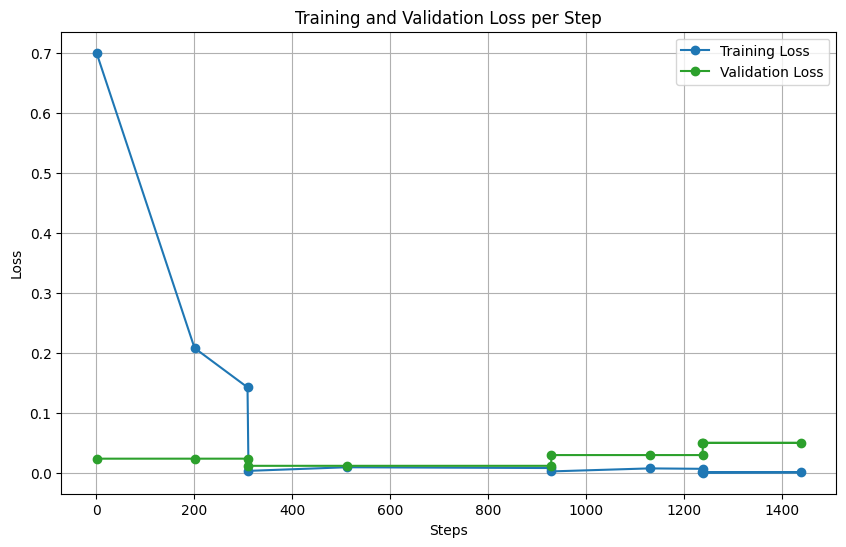

In [28]:
steps_32 = [1, 201, 309, 310 + 1, 310 + 201, 2 * 309 + 310, 2 * 309 + 310 + 1, 
         2 * 309 + 310 + 201, 3 * 309 + 310, 3 * 309 + 310 + 1, 
         3 * 309 + 310 + 201, 4 * 309]

losses = [
    0.7003, 0.2084, 0.1430, 
    0.0039, 0.0099, 0.0086,
    0.0030, 0.0080, 0.0073,
    0.0008, 0.0015, 0.0018
]

val_losses = [
    0.0242, 0.0242, 0.0242, 
    0.0123, 0.0123, 0.0123,
    0.0302, 0.0302, 0.0302,
    0.0505, 0.0505, 0.0505
]

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(steps_32, losses, 'o-', label='Training Loss', color='tab:blue')
plt.plot(steps_32, val_losses, 'o-', label='Validation Loss', color='tab:green')

# Etiquetas y título
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Step')
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

In [25]:
model = TransformerClass()

model_save_path = f'..\model_weights\BERT_L_CLS\model_epoch_2_acc0.9965.pth'
model.load_state_dict(torch.load(model_save_path, weights_only=False))

model.to(device)

TransformerClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [26]:
def test(test_loader, model, device):
    model.eval()
    test_loss = 0
    correct_predictions = 0
    total_predictions = 0

    all_targets = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for data in test_loader:
            input_ids = data['ids'].to(device)
            attention_mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask, token_type_ids)
            test_loss += torch.nn.functional.cross_entropy(logits, targets, reduction='sum').item()

            # Predicciones y probabilidades
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Acumulamos
            all_probs.extend(probs.cpu().numpy()[:, 1])  # Probabilidades de clase positiva
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.argmax(dim=1).cpu().numpy())  # Para multi-clase, usa el índice

            correct_predictions += (preds == targets.argmax(dim=1)).sum().item()
            total_predictions += targets.size(0)

    avg_test_loss = test_loss / total_predictions
    accuracy = correct_predictions / total_predictions

    # Métricas adicionales
    roc_auc = roc_auc_score(all_targets, all_probs)
    brier = brier_score_loss(all_targets, all_probs)
    f1 = f1_score(all_targets, all_preds, average='weighted')  # Ajusta el promedio si es necesario
    f05 = precision_recall_fscore_support(all_targets, all_preds, average='weighted', beta=0.5)[2]

    # C@1
    correct = sum(1 for t, p in zip(all_targets, all_preds) if t == p)
    c_at_1 = correct / len(all_preds)

    return avg_test_loss, accuracy, roc_auc, brier, c_at_1, f1, f05


# Ejemplo de uso
test_loss, test_accuracy, roc_auc, brier, c_at_1, f1, f05 = test(test_loader, model, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"C@1: {c_at_1:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F0.5 Score: {f05:.4f}")

Test Loss: 0.0063
Test Accuracy: 0.9972
ROC-AUC: 1.0000
Brier Score: 0.0019
C@1: 0.9972
F1 Score: 0.9972
F0.5 Score: 0.9972
